<a href="https://colab.research.google.com/github/maxskoda/NR_autoreduce/blob/master/OleicAcid_onSi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install refnx

In [ ]:
! git clone 'https://github.com/maxskoda/NR_autoreduce/'

In [ ]:
pip install numpy

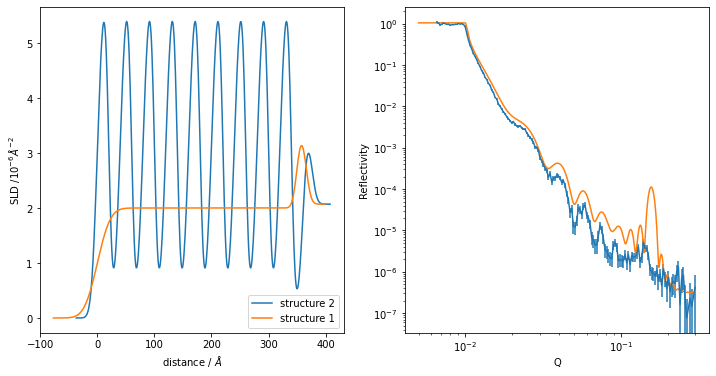

In [5]:
#@title Default title text 
film_thickness =  350#@param {type:"number"}
import matplotlib.pyplot as plt
import numpy as np
#import os.path
import time as tm
import pandas as pd
import pickle
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

start_time = tm.time()

import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain, Transform

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, MixedReflectModel, ReflectModel, Structure, Stack

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset


data_DiscA_1 = ReflectDataset('IvsQ_55159_55160.dat')
data_DiscA_1.name = "1pc_2000RPM"

#get_ipython().run_line_magic('matplotlib', 'notebook')
#fig, ax = plt.subplots()
# data_DiscA_1.plot()
# plt.xlabel('Q')
# plt.ylabel('Reflectivity')
# plt.yscale('log')
# plt.xscale('log')

## create slabs
si = SLD(2.07, name='Si')
sio2 = SLD(3.47, name='SiO2')
film = SLD(2.0, name='film')
air = SLD(0.0, name='air')
OA = SLD(6.097, name='OA')#
SO = SLD(0.204, name='SO')

# first number is thickness, second number is roughness
# a native oxide layer
sio2_layer = sio2(15.7, 6.4)

# the film of interest
film_layer = film(film_thickness, 18)
OA_layer = OA(20,8)
SO_layer = SO(20,5)

#sio2_layer.thick.setp(bounds=(10, 100), vary=True)
#sio2_layer.rough.setp(bounds=(1, 30), vary=True)

film_layer.thick.setp(bounds=(300, 500), vary=True)
film_layer.sld.real.setp(bounds=(0.1, 4), vary=True)
film_layer.rough.setp(bounds=(0.1, 45), vary=True)

OA_layer.thick.setp(bounds=(18, 25), vary=True)
OA_layer.sld.real.setp(bounds=(0, 6.5), vary=True) #
OA_layer.rough.setp(bounds=(5, 15), vary=True)

SO_layer.thick.setp(bounds=(18, 25), vary=True)
SO_layer.sld.real.setp(bounds=(0.2, 6.5), vary=True)
SO_layer.rough.setp(bounds=(5, 15), vary=True)

si_back = si(0,6.8)

# define which model to use ***CHANGE THIS***
model_no = 1
MCMC = False

if model_no == 1:
    # Make a multilayer by using a Stack Component
    stack = Stack(components=OA_layer|SO_layer, repeats=9)
    #stack |= OA_layer
    #stack |= SO_layer
    #stack.repeats = 10.0
    #stack.repeats.setp(bounds=(2,10),vary=True) # vary repeats
    # assemble the structure
    structure1 = air | film_layer | sio2_layer | si_back 
    structure2 = air | stack | sio2_layer | si_back
    
    
    
    model = MixedReflectModel((structure1,structure2), scales=(0.95,0.1), bkg=3e-7, dq=2.5)
    model.scales[0].setp(bounds=(0.0, 1.2), vary=True)
    model.scales[1].setp(bounds=(0.0, 1.2), vary=True)
    model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)

elif model_no == 7:
    # Make a multilayer by using a Stack Component
    stack = Stack(components=OA_layer|SO_layer, repeats=6)
    #stack |= OA_layer
    #stack |= SO_layer
    #stack.repeats = 10.0
    stack.repeats.setp(bounds=(2,6),vary=True) # vary repeats
    # assemble the structure
    structure1 = air | film_layer | stack | sio2_layer | si_back 
    
    # now only 1 structure to model
    model = ReflectModel(structure1,scale=1,bkg=3e-7, dq=2.5)
    model.scale.setp(bounds=(0,1.2),vary=True)
    model.bkg.setp(bounds=(1e-9,1e-6),vary=True)
    
elif model_no == 8:
    # Make a multilayer by using a Stack Component
    stack = Stack(components=OA_layer|SO_layer, repeats=6)
    #stack |= OA_layer
    #stack |= SO_layer
    #stack.repeats = 10.0
    stack.repeats.setp(bounds=(2,6),vary=True) # vary repeats
    # assemble the structure
    structure1 = air | stack | film_layer | sio2_layer | si_back 
    
    # now only 1 structure to model
    model = ReflectModel(structure1,scale=1,bkg=3e-7, dq=2.5)
    model.scale.setp(bounds=(0,1.2),vary=True)
    model.bkg.setp(bounds=(1e-9,1e-6),vary=True)

# check model

q = np.linspace(0.005, 0.3, 1001)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

# plot the SLD profile
if model_no == 1:
    ax1.plot(*structure2.sld_profile(),label='structure 2')
ax1.plot(*structure1.sld_profile(),label='structure 1')
ax1.set_ylabel('SLD /$10^{-6} \AA^{-2}$')
ax1.set_xlabel('distance / $\AA$');
ax1.legend()

data_DiscA_1.plot(plt)
ax2.plot(q, model(q))
ax2.set_xlabel('Q')
ax2.set_ylabel('Reflectivity')
ax2.set_yscale('log')
ax2.set_xscale('log')
